<a href="https://colab.research.google.com/github/j0rge-20/Precip/blob/main/3_Precipitacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

#!pip install -q tensorflow-gpu
!pip install pandasql

import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import pandasql as ps
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from pandasql import sqldf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Dropout

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

#sql function def
pysqldf = lambda q: sqldf(q, globals())


#load dataset
#@title Loading dataset
path = 'https://raw.githubusercontent.com/j0rge-20/Precip/main/DatasetFull_v2.csv'


df = pd.read_csv(path,
                 parse_dates=['Fecha'],
                 index_col="Fecha")


#load dataset
#@title Loading dataset
path2 = 'https://raw.githubusercontent.com/j0rge-20/Precip/main/Dataset_features.csv'


dff = pd.read_csv(path2,
                 parse_dates=['Fecha'],
                 index_col="Fecha")

print('#### Revisar repetidos dataframe ##########')
print (sqldf('select Estacion from (select Anio,Mes,Estacion, count(1) as qty from df  group by Anio,Mes,Estacion) where qty > 1 group by Estacion'))

#### Revisar repetidos dataframe ##########
Empty DataFrame
Columns: [Estacion]
Index: []


In [ ]:
###########################################   Funciones   #####################################################################

#array estaciones
estaciones = ['2120540','2306507','2120557','2401519','2120562','2120548','2120559','2120561','2120629','2401513','2120639','2120630','2120646','2120641','2120644','2120647','2119514','2306517','2306516'] 

#función para crear dataframe por estaction
def sub_esta (df,cod):
    return df.query('Estacion in @cod')

#funcion para crear dataframe por mes
def sub_mes (df,m):  
  return df.query('Mes in @m')

#funcion para crear dataset por estacion y mes
def sub_pred (df,cod_est,mes,tam):
  return df.query('Estacion in @cod_est & Mes in @mes').sort_values(by=['Anio']).tail(tam)  


# crear secuencia 
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# predicciones para todas las estaciones



In [ ]:
#################### definicion dataset

cod_estacion = estaciones[2]

#dataset entrenamiento
df_est = sub_esta (df,cod_estacion)


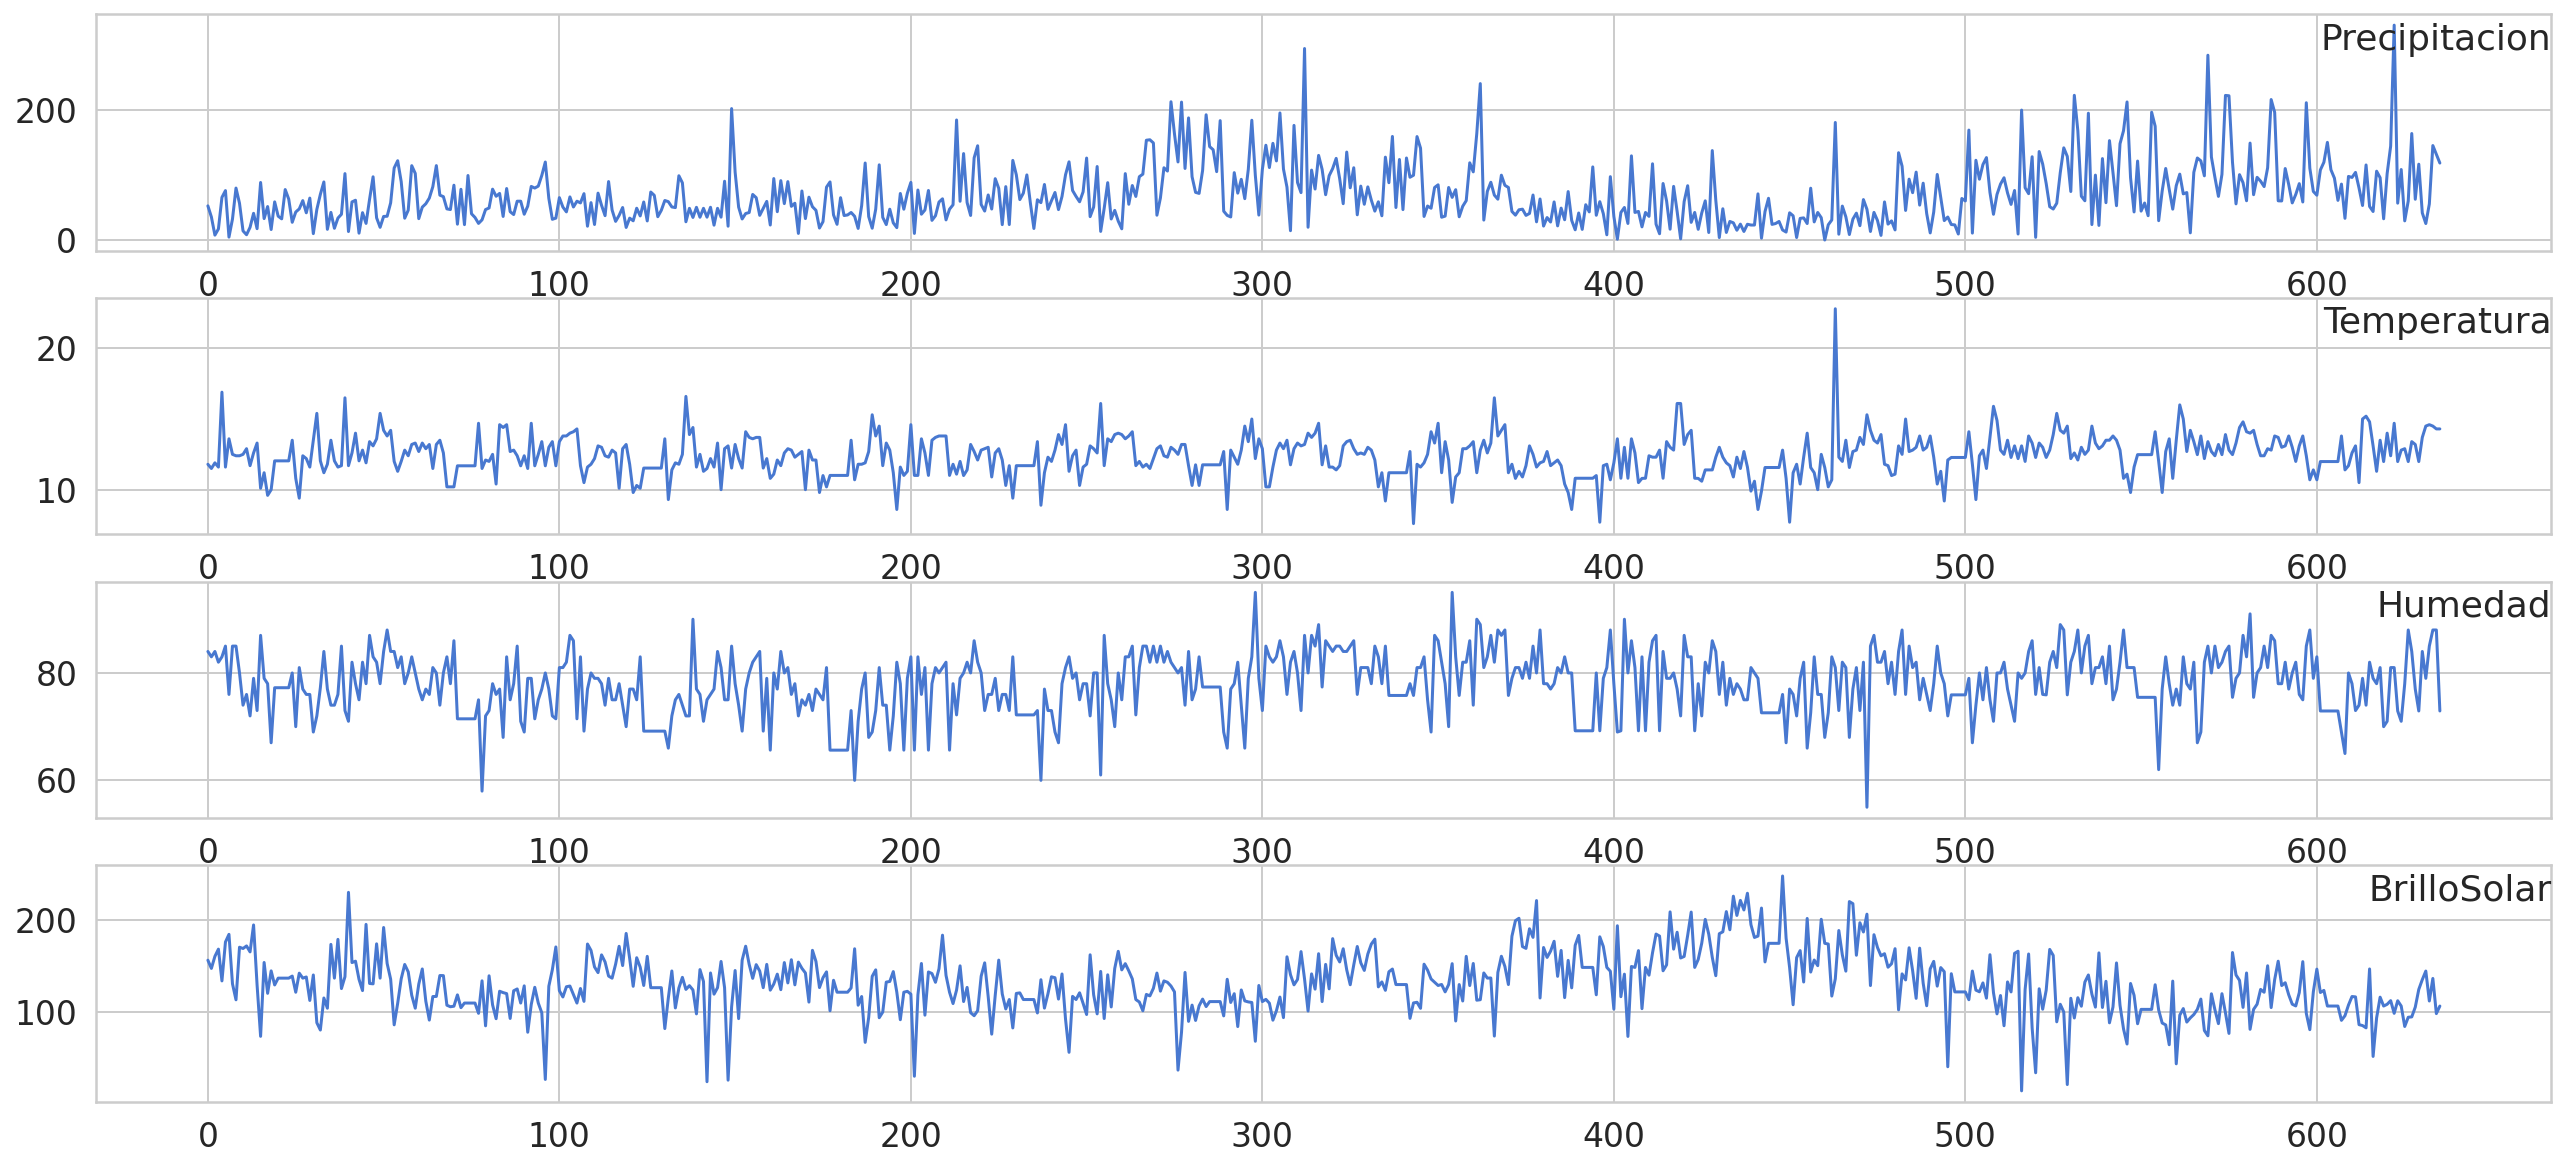

In [ ]:
#graphics station
#################graphics properties####################################
%matplotlib inline
%config InlineBackend.figure_format='retina'
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 22, 10
#################graphics properties####################################


df_graphic_station = df_est


val = df_graphic_station.values
features = [3,4,5,6]

i =1
plt.figure()
for feature in features:
    plt.subplot(len(features),1,i)
    plt.plot(val[:,feature])
    plt.title(df_graphic_station.columns[feature], y= 0.8 , loc = 'right')
    i += 1


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/lo

Epoch 1/30
14/14 [==============================] - 4s 98ms/step - loss: 0.5432 - val_loss: 0.7567
Epoch 2/30
14/14 [==============================] - 0s 17ms/step - loss: 0.5056 - val_loss: 0.7461
Epoch 3/30
14/14 [==============================] - 0s 17ms/step - loss: 0.5149 - val_loss: 0.7450
Epoch 4/30
14/14 [==============================] - 0s 16ms/step - loss: 0.5159 - val_loss: 0.7497
Epoch 5/30
14/14 [==============================] - 0s 16ms/step - loss: 0.5097 - val_loss: 0.7506
Epoch 6/30
14/14 [==============================] - 0s 17ms/step - loss: 0.5019 - val_loss: 0.7506
Epoch 7/30
14/14 [==============================] - 0s 17ms/step - loss: 0.5010 - val_loss: 0.7508
Epoch 8/30
14/14 [==============================] - 0s 32ms/step - loss: 0.4958 - val_loss: 0.7532
Epoch 9/30
14/14 [==============================] - 0s 16ms/step - loss: 0.4902 - val_loss: 0.7555
Epoch 10/30
14/14 [==============================] - 0s 17ms/step - loss: 0.4891 - val_loss: 0.7584
Epoch 11/

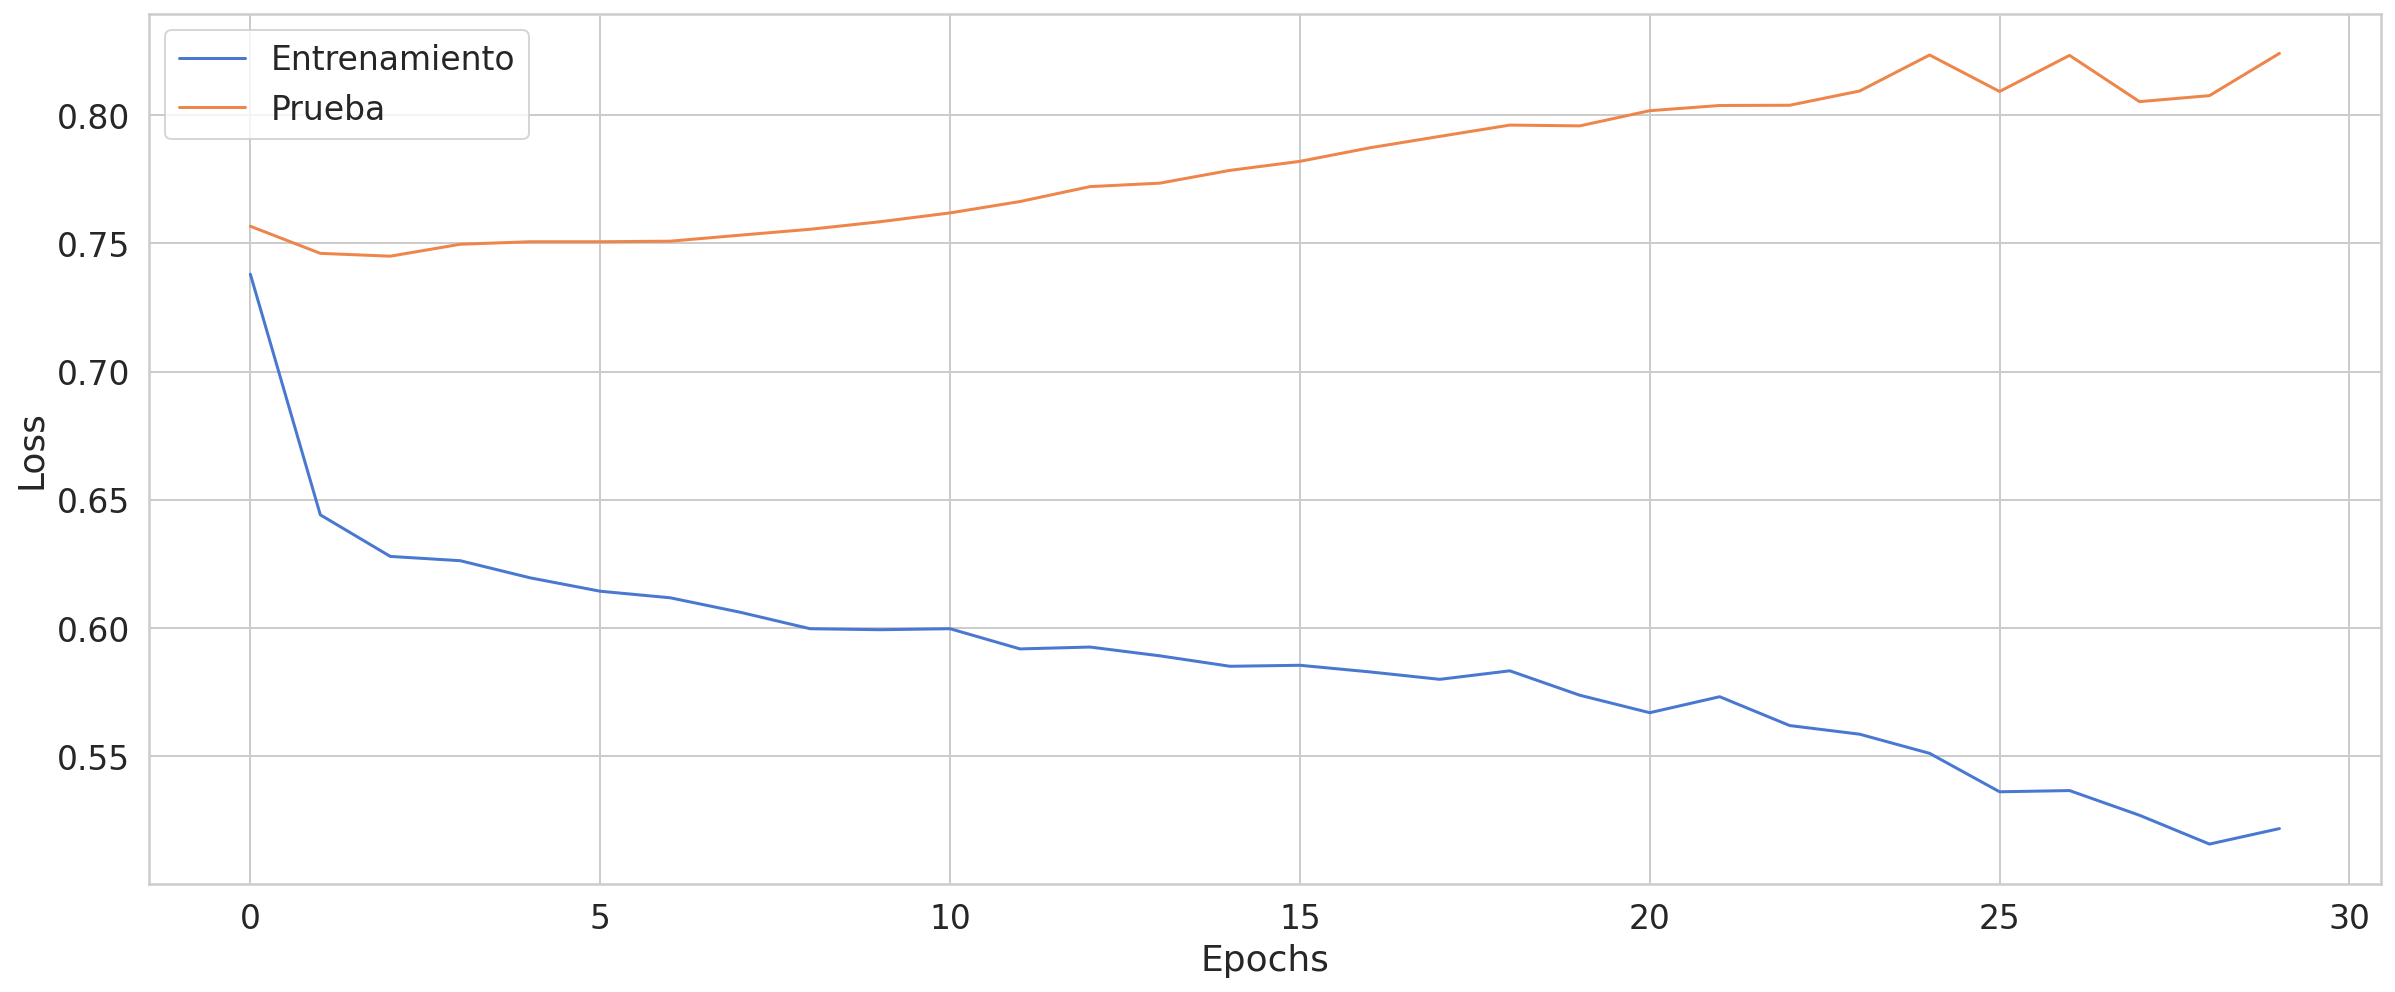

In [ ]:
#Define train & test - Pick a month


#dataset features
df_an = df_est.copy()
#dataset (y)
df_any = df_est.copy()



#remover columnas adicionales entrenamiento
df_an.drop('Anio', inplace=True, axis=1)
df_an.drop('Mes', inplace=True, axis=1)
df_an.drop('Estacion', inplace=True, axis=1)
df_an.drop('Precipitacion', inplace=True, axis=1)


########################################PARAMETROS MODELO##################################
#tamanio entrenamiento 
porcentaje_en = 0.8 
#tamanio segmento dataset
time_steps = 10
#parametros construccion modelo
units_lstm = 128
drate = 0.1
#parametros fit
epochs_ = 30
batchsize_ = 32
val_split = 0.1
########################################PARAMETROS MODELO##################################


# tamanio entrenamiento
tam_en = int(len(df_an)*porcentaje_en)
#tamanio pruebas
tam_pru = len(df_an) - tam_en

#dataframe entrenamiento
df_en   = df_an.iloc[0:tam_en]
dfy_en  = df_any.iloc[0:tam_en]


#dataframe pruebas [tamanio entrenamiento,tamanio dataframe]
df_pr =   df_an.iloc[tam_en:len(df_an)]
dfy_pr =  df_any.iloc[tam_en:len(df_an)]

from sklearn.preprocessing import RobustScaler

#caracteristicas climaticas
caract_col = ['Temperatura','Humedad','BrilloSolar']
caract_transformer = RobustScaler()
preci_transformer = RobustScaler()

caract_transformer = caract_transformer.fit(df_en[caract_col].to_numpy())

preci_transformer = preci_transformer.fit(dfy_en[['Precipitacion']])



#asignar transformadores  dataset entrenamiento
df_en.loc[:,caract_col] = caract_transformer.transform(df_en[caract_col].to_numpy())
dfy_en['Precipitacion'] = preci_transformer.transform(dfy_en[['Precipitacion']])

#asignar transformadores dataset pruebas
df_pr.loc[:,caract_col] = caract_transformer.transform(df_pr[caract_col].to_numpy())
dfy_pr['Precipitacion'] = preci_transformer.transform(dfy_pr[['Precipitacion']])

#asignar transformadores dataset prediccion
#df_anpr.loc[:,caract_col] = caract_transformer.transform(df_anpr[caract_col].to_numpy())
#df_anypr['Temperatura'] = preci_transformer.transform(df_anypr[['Temperatura']])



# secuencias entrenamiento
x_en,y_en = create_dataset(df_en,dfy_en.Precipitacion,time_steps)

# secuencias pruebas
x_pr,y_pr = create_dataset(df_pr,dfy_pr.Precipitacion,time_steps)

#secuencias prediccion
x_pre,y_pre = create_dataset(df_anpr,df_anypr.Temperatura,time_steps)


#creacion modelo
modelo = Sequential()

modelo.add(Bidirectional(
                          LSTM(units=units_lstm, input_shape=(x_en.shape[1], x_en.shape[2]))
                        )
          )
modelo.add(Dropout(rate=drate))
modelo.add(Dense(units=1))
modelo.compile(loss='mean_squared_error', optimizer='adam')

#entrenar modelo
history = modelo.fit(x_en, y_en,epochs=epochs_, batch_size=batchsize_,validation_split=val_split,shuffle=False)


#################graphics properties####################################
%matplotlib inline
%config InlineBackend.figure_format='retina'
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 20, 8
#################graphics properties####################################
loss = history.history['loss']
val_loss= history.history['val_loss']
plt.plot(loss, label='Entrenamiento')
plt.plot(val_loss, label='Prueba')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();


##################### mean squared error #############################
#https://www.youtube.com/watch?v=fWFVXEXwIBQ

In [ ]:


# generar predicciones utilizando el dataset de pruebas
y_pred = modelo.predict(x_pr)

#dimensiones arrays
print("Dimensiones - Secuencia")
print("x_en ",x_en.shape)
print("y_en ",y_en.shape)
print("x_pr ",x_pr.shape)
print("y_pr ",y_pr.shape)
print("y_pred", y_pred.shape)

print("y_pred[0]", y_pred[0])
print("y_pred[0,0]", y_pred[0,0])

Dimensiones - Secuencia
x_en  (498, 10, 3)
y_en  (498,)
x_pr  (118, 10, 3)
y_pr  (118,)
y_pred (118, 1)
y_pred[0] [0.5503947]
y_pred[0,0] 0.5503947


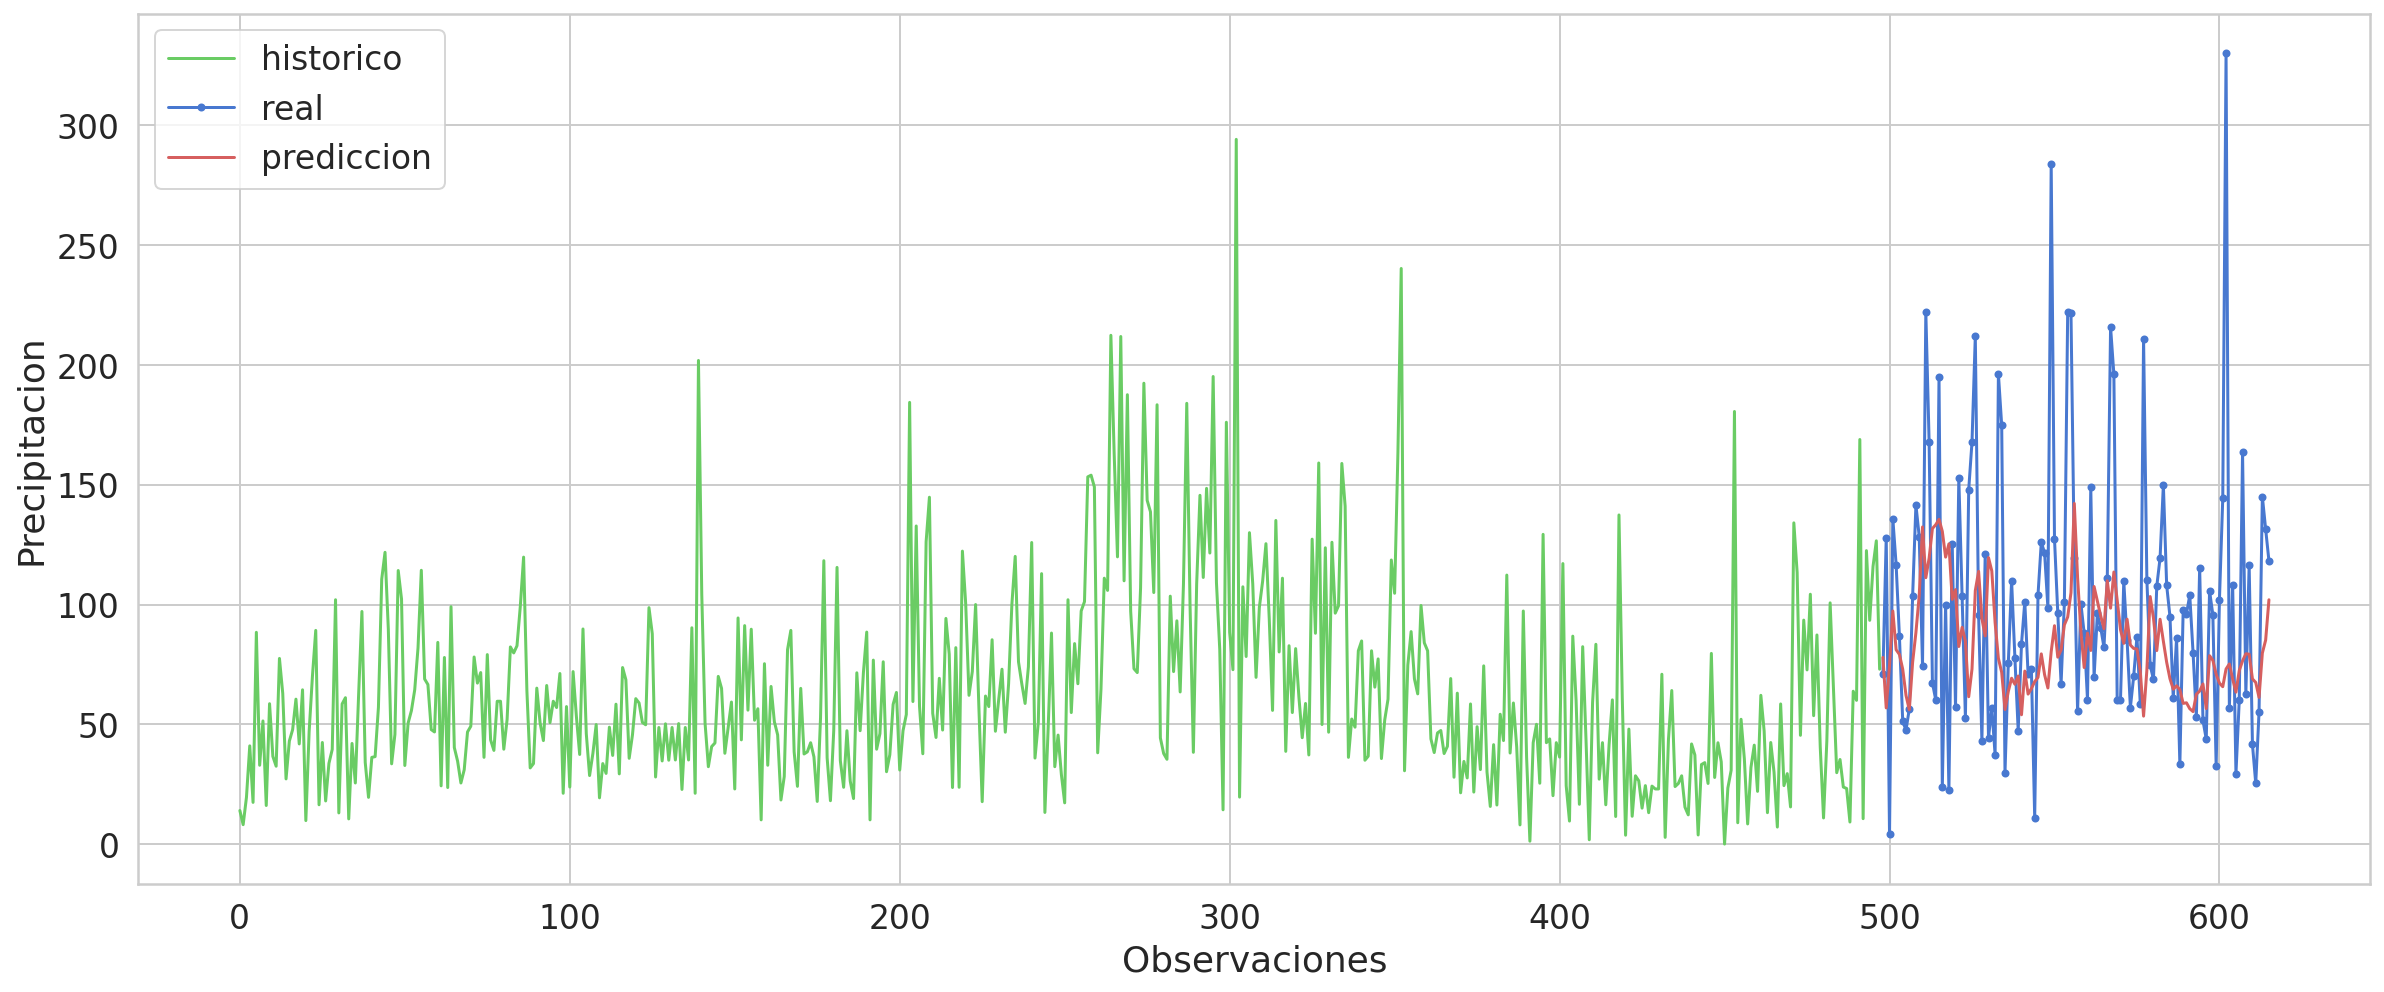

In [ ]:
y_en_inv = preci_transformer.inverse_transform(y_en.reshape(1, -1))
y_pr_inv = preci_transformer.inverse_transform(y_pr.reshape(1, -1))
y_pred_inv = preci_transformer.inverse_transform(y_pred)

#graficar predicciones
plt.plot(np.arange(0, len(y_en)), y_en_inv.flatten(), 'g', label="historico")
plt.plot(np.arange(len(y_en), len(y_en) + len(y_pr)), y_pr_inv.flatten(), marker='.', label="real")
plt.plot(np.arange(len(y_en), len(y_en) + len(y_pr)), y_pred_inv.flatten(), 'r', label="prediccion")
plt.ylabel('Precipitacion')
plt.xlabel('Observaciones')
plt.legend()
plt.show();

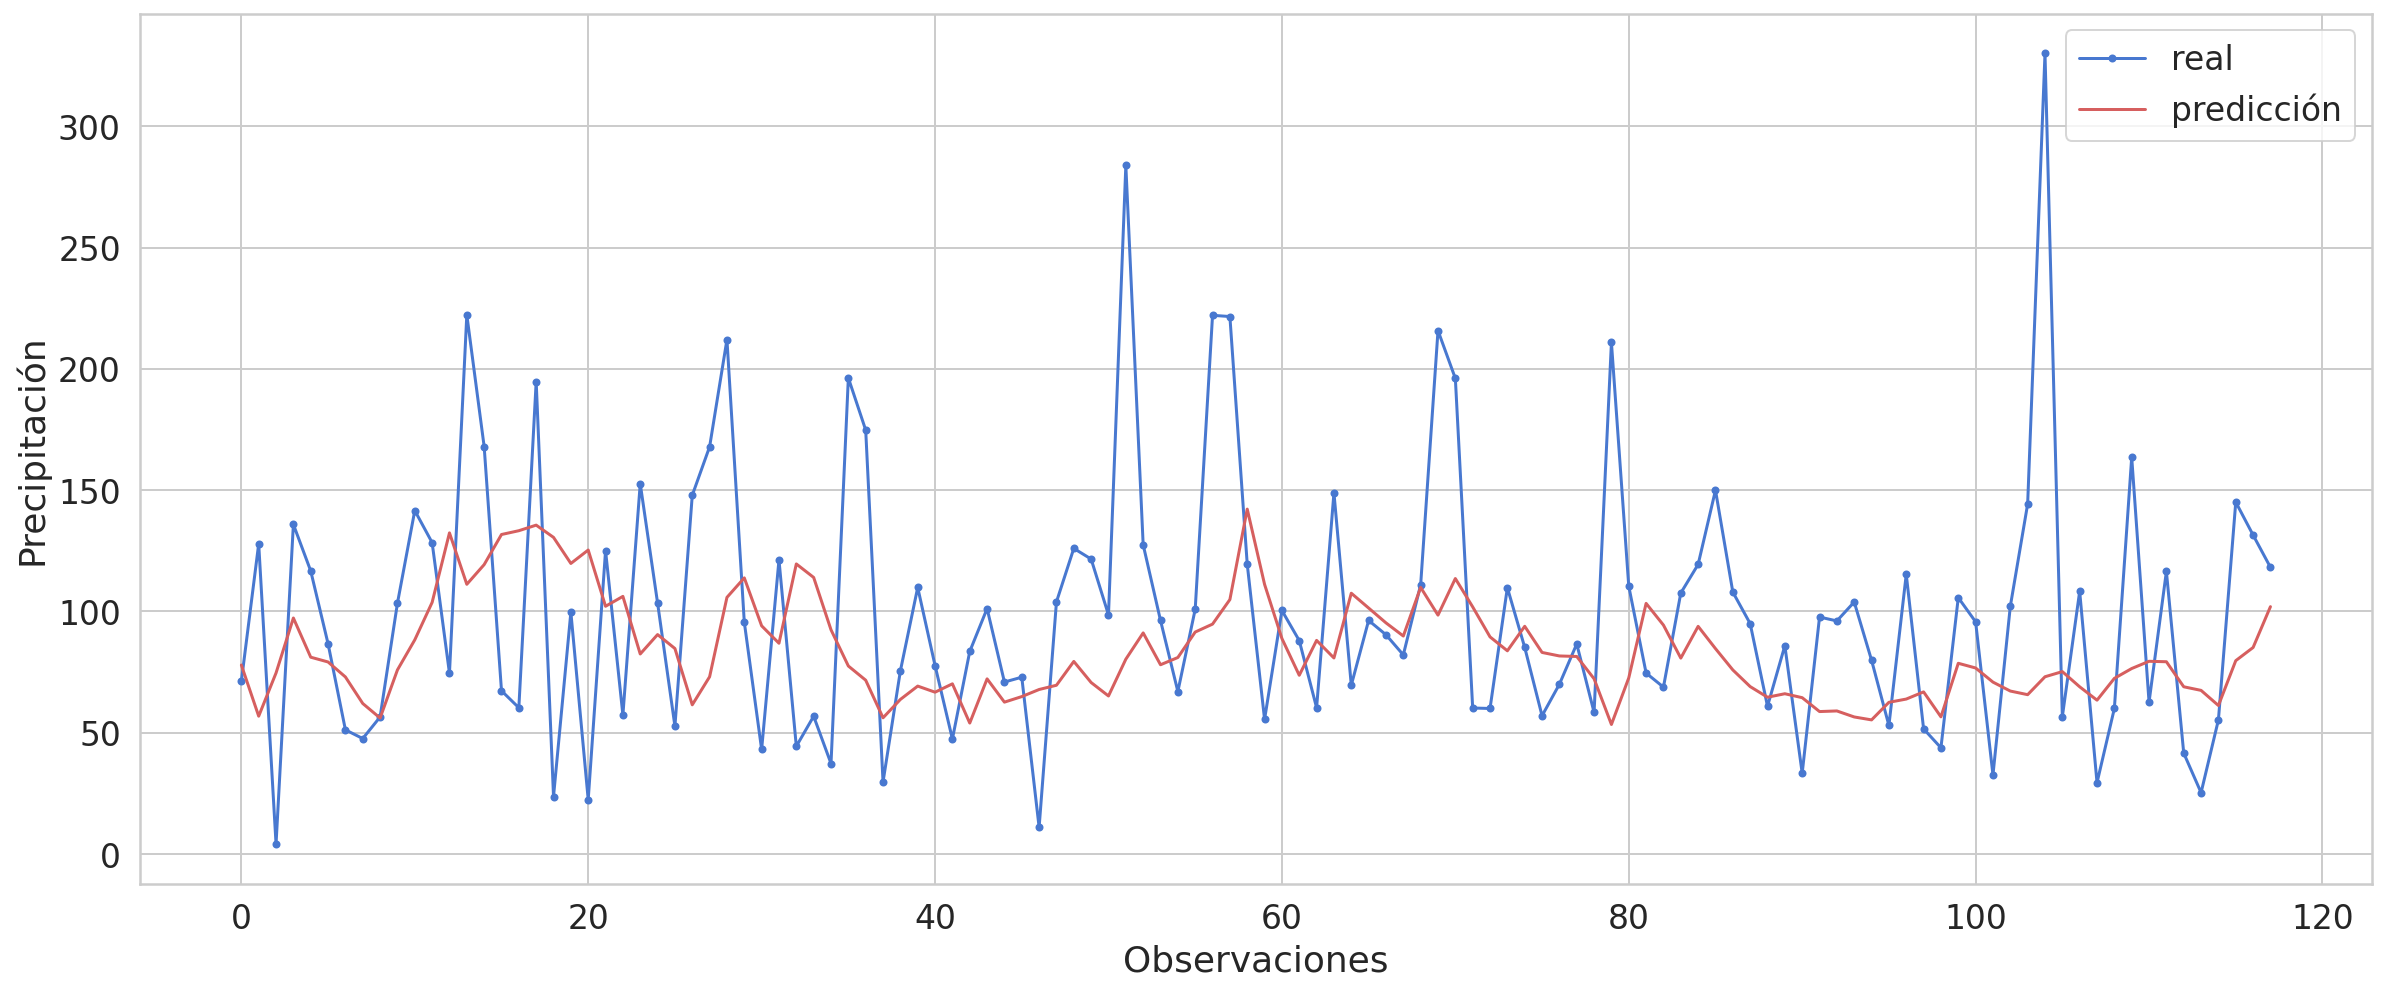

In [ ]:
plt.plot(y_pr_inv.flatten(), marker='.', label="real")
plt.plot(y_pred_inv.flatten(), 'r', label="predicción")
plt.ylabel('Precipitación')
plt.xlabel('Observaciones')
plt.legend()
plt.show();

In [ ]:
def pred (df):
 estaciones = ['2120540','2306507','2120557','2401519','2120562','2120548','2120559','2120561','2120629','2401513','2120639','2120630','2120646','2120641','2120644','2120647','2119514','2306517','2306516'] 
 rows = []
 for e in estaciones:
      for i in range (12):
            mes = str(i+1)
            mm = mes
            if (len(mes)==1): mm = '0'+mes
            df_pred = sub_pred (df,str(e),mes,11)
            #crear  x & y
            df_anpr = df_pred.copy()
            df_anypr = df_pred.copy()
            #remover columnas adicionales prediccion
            df_anpr.drop('Anio', inplace=True, axis=1)
            df_anpr.drop('Mes', inplace=True, axis=1)
            df_anpr.drop('Estacion', inplace=True, axis=1)
            df_anpr.drop('Precipitacion', inplace=True, axis=1)
            #asignar transformadores dataset prediccion
            df_anpr.loc[:,caract_col] = caract_transformer.transform(df_anpr[caract_col].to_numpy())
            df_anypr['Temperatura'] = preci_transformer.transform(df_anypr[['Temperatura']])
            #secuencias prediccion
            x_pre,y_pre = create_dataset(df_anpr,df_anypr.Temperatura,time_steps)
            #generar predicciones utilizando los datos generados
            y_pred2 = modelo.predict(x_pre)
            #reversar transformador
            y_pred_inv2 = preci_transformer.inverse_transform(y_pred2)
            #agregar resultado en array
            rows.append(['2021-'+mm+'-01','2021',mes,str(e),y_pred_inv2[0,0]]) 
 dd=  pd.DataFrame(rows, columns=["Fecha", "Anio","Mes","Estacion","Precipitacion"])
 return dd

##predicciones para todas las estaciones
total = pred (df)

#pred (df,'2120540')

In [ ]:

sqldf('select * from total where estacion = '+cod_estacion+' ')
#sqldf('select * from total where Precipitacion < 0')

,Fecha,Anio,Mes,Estacion,Precipitacion
0,2021-01-01,2021,1,2120557,57.379894
1,2021-02-01,2021,2,2120557,67.182175
2,2021-03-01,2021,3,2120557,103.735878
3,2021-04-01,2021,4,2120557,107.521774
4,2021-05-01,2021,5,2120557,101.992012
5,2021-06-01,2021,6,2120557,79.462830
6,2021-07-01,2021,7,2120557,61.252129
7,2021-08-01,2021,8,2120557,56.381153
8,2021-09-01,2021,9,2120557,83.506752
9,2021-10-01,2021,10,2120557,79.609764


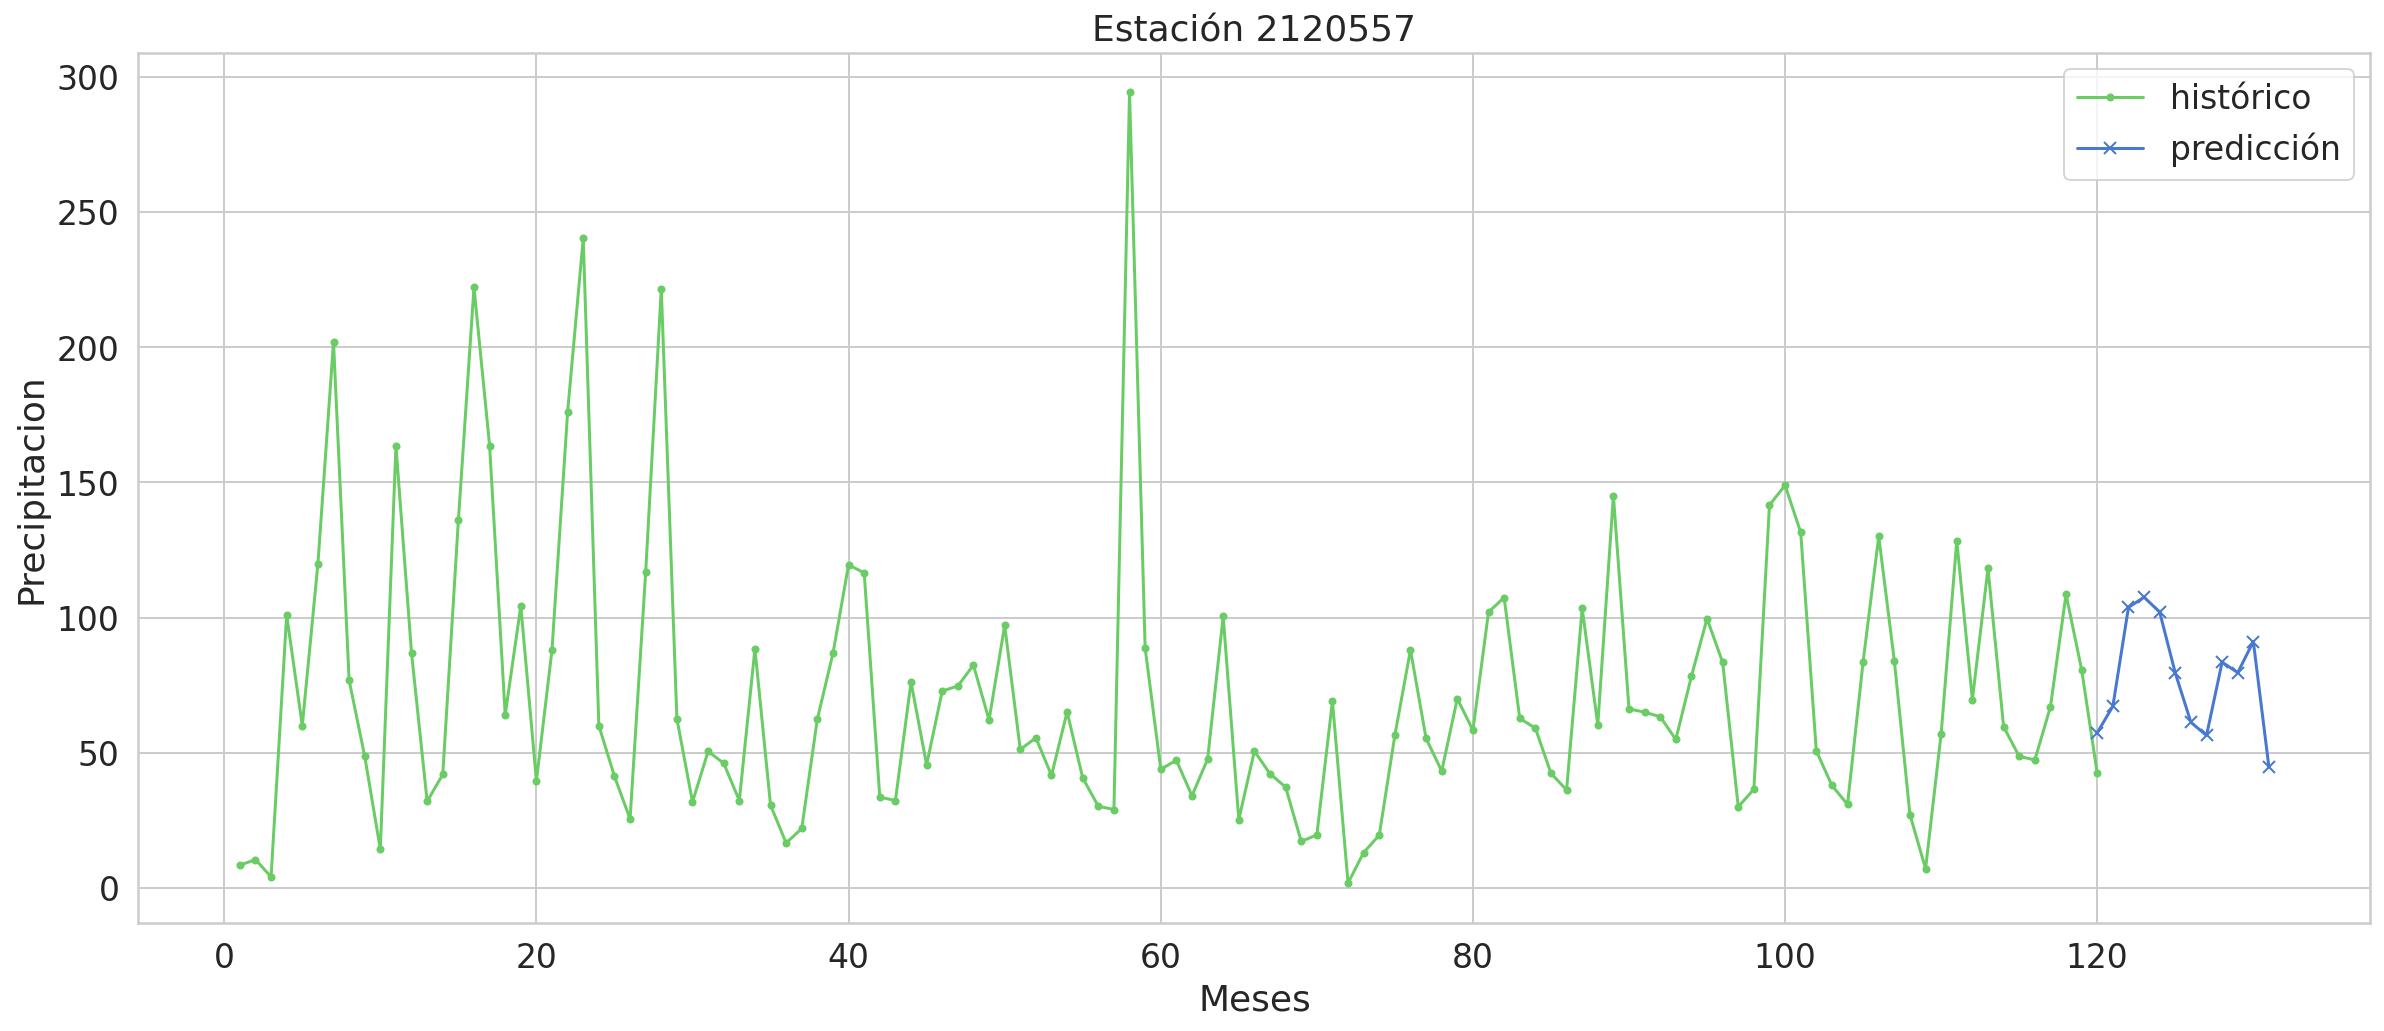

In [ ]:
#combine data & predictions

tam=120
estaciones = ['2120540','2306507','2120557','2401519','2120562','2120548','2120559','2120561','2120629','2401513','2120639','2120630','2120646','2120641','2120644','2120647','2119514','2306517','2306516'] 
esta = estaciones[2]
dfh = df.copy() 
dfp = total.copy()

dfhh = sqldf('select Anio, Mes, Estacion, Precipitacion from dfh where Estacion = '+ esta + '').sort_values(by=['Anio','Mes']).tail(tam)
dfpp = sqldf('select Anio, Mes, Estacion, Precipitacion from dfp where Estacion = '+ esta + '')
#df_t = pd.concat([dfhh,dfpp])


dfhh.insert(0, 'New_ID', range(1, 1 + tam))
dfpp.insert(0, 'New_ID', range(tam,tam+len(dfpp) ))


plt.plot(dfhh['New_ID'],dfhh['Precipitacion'] , 'g', marker='.', label="histórico")
plt.plot(dfpp['New_ID'],dfpp['Precipitacion'] , 'b',marker='x', label="predicción")

plt.ylabel('Precipitacion')
plt.xlabel('Meses')
plt.title('Estación '+esta , loc = 'center')
plt.legend()
plt.show();


In [ ]:
# #export fixed dataframe
# #export csv file to local computer
from google.colab import files
total.to_csv('precip.csv',index=False)
files.download('precip.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>